# Imports

In [225]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from scipy.stats import kendalltau
from cdlib import algorithms, evaluation
from matplotlib.colors import rgb2hex

# Load data

In [226]:
data_df = pd.read_csv("../data/medium.in", sep=" ", index_col=None, header=None, names=["source", "target"])

print(data_df.head())

   source  target
0       2       1
1       2      10
2       2      20
3       2      29
4       2      33


# Create networkit graph object

In [227]:
g = nk.Graph(directed=True)

for row in data_df[["source", "target"]].to_records(index=False).tolist():
    g.addEdge(row[0], row[1], addMissing=True)

In [228]:
print("Number of self loops: ", g.numberOfSelfLoops())

Number of self loops:  0


# Question 3.1

In [229]:
print("Number of directed edges: ", g.numberOfEdges())

Number of directed edges:  12864


# Question 3.2

In [230]:
print("Number of users(nodes) in the network: ", g.numberOfNodes())

Number of users(nodes) in the network:  2240


In [231]:
print("Number of connected users(nodes) in the network: ", len(set(data_df["source"].to_list() + data_df["target"].to_list())))

Number of connected users(nodes) in the network:  2239


# Question 3.2

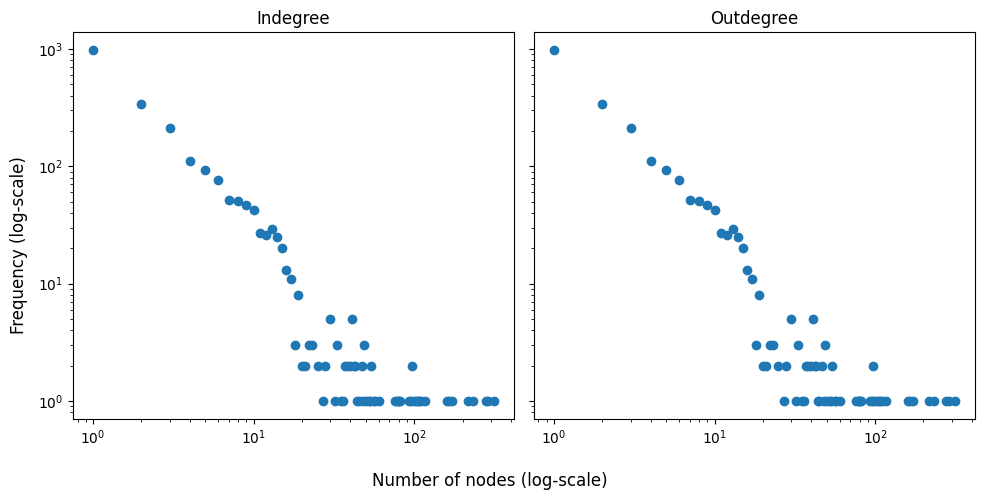

In [232]:
indegree_counts = np.unique([g.degreeIn(node_id) for node_id in g.iterNodes()], return_counts=True)
outdegree_counts = np.unique([g.degreeOut(node_id) for node_id in g.iterNodes()], return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, tight_layout=True)

ax[0].scatter(indegree_counts[0], indegree_counts[1])
ax[1].scatter(outdegree_counts[0], outdegree_counts[1])

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

fig.supxlabel("Number of nodes (log-scale)")
fig.supylabel("Frequency (log-scale)")

ax[0].title.set_text("Indegree")
ax[1].title.set_text("Outdegree")

plt.show()

# Question 3.4

In [233]:
scc = nk.components.StronglyConnectedComponents(g)
scc.run()

print(f"Number of strongly connected components: ", scc.numberOfComponents())

Number of strongly connected components:  10


In [234]:
wcc = nk.components.WeaklyConnectedComponents(g)
wcc.run()

print(f"Number of weakly connected components: ", wcc.numberOfComponents())

Number of weakly connected components:  10


In [235]:
largest_scc_nodes = scc.getComponents()[tuple(sorted(scc.getComponentSizes().items(), key=lambda item: item[1], reverse=True))[0][0]]
largest_scc = nk.graphtools.subgraphFromNodes(g, largest_scc_nodes)

print(f"Number of nodes in largest strongly connected component: ", largest_scc.numberOfNodes())
print(f"Number of edges in largest strongly connected component: ", largest_scc.numberOfEdges())

Number of nodes in largest strongly connected component:  2217
Number of edges in largest strongly connected component:  12836


# Question 3.5

For how to handle directionality, refer https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html

In [236]:
print("Average local clustering coefficient: ", nk.globals.clustering(g))

Average local clustering coefficient:  0.07152783809606532


# Question 3.6

In [255]:
largest_wcc_nodes = wcc.getComponents()[tuple(sorted(wcc.getComponentSizes().items(), key=lambda item: item[1], reverse=True))[0][0]]
largest_wcc = nk.graphtools.subgraphFromNodes(g, largest_wcc_nodes)

APSP = nk.distance.APSP(largest_wcc) 
APSP.run()

distance_counts = np.unique(APSP.getDistances(), return_counts=True)

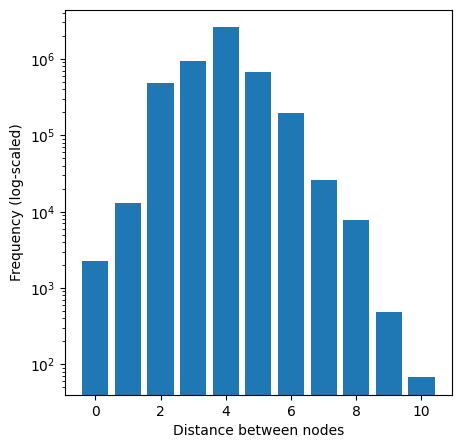

In [256]:
plt.figure(figsize=(5,5))

plt.bar(distance_counts[0][:-1], distance_counts[1][:-1], align="center")

plt.yscale("log")

plt.xlabel("Distance between nodes")
plt.ylabel("Frequency (log-scaled)")

plt.show()

# Question 3.7

In [239]:
centrality = {}

In [245]:
# Degree centrality
centrality["degree"] = nk.centrality.DegreeCentrality(g, normalized=True)
centrality["degree"].run()

In [246]:
# Betweenness centrality
centrality["betweenness"] = nk.centrality.Betweenness(g, normalized=True)
centrality["betweenness"].run()

In [247]:
# Pagerank centrality
centrality["pagerank"] = nk.centrality.PageRank(g)
centrality["pagerank"].run()

In [248]:
rankings_df = pd.DataFrame({"degree": [node_id for node_id, score in centrality["degree"].ranking()[:20]], 
                            "betweenness": [node_id for node_id, score in centrality["betweenness"].ranking()[:20]], 
                            "pagerank": [node_id for node_id, score in centrality["pagerank"].ranking()[:20]]})
              
print(rankings_df)          

    degree  betweenness  pagerank
0       33           33        33
1      129           10       129
2      355          355       355
3       73          129        10
4      124           73        73
5       10          124       124
6       51           38        38
7      159           90        51
8       90          312        90
9        8           51       159
10      95          159       312
11     312           95        95
12      38          284       284
13     227          198         8
14     284            8        29
15    1666          227       442
16     442           50        50
17      50          239       198
18     505          442       227
19     198          168      1666


<AxesSubplot:>

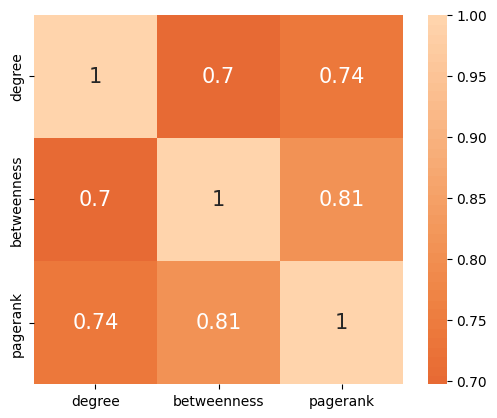

In [249]:
kendalltau_corr = {}

for measure_x in rankings_df.columns:
    kendalltau_corr[measure_x] = {}

    for measure_y in rankings_df.columns:
            
        y_true = pd.DataFrame({"nodes": [node_id for node_id, score in centrality[measure_x].ranking()[:20]], "ranking_x": [score for node_id, score in centrality[measure_x].ranking()[:20]]})
        y_score = pd.DataFrame({"nodes": [node_id for node_id, score in centrality[measure_y].ranking()[:20]], "ranking_y": [score for node_id, score in centrality[measure_y].ranking()[:20]]})
            
        y_df = y_true.merge(y_score, how="outer", on="nodes").fillna(0)

        kendalltau_corr[measure_x][measure_y], _ = kendalltau(y_df["ranking_x"], y_df["ranking_y"])

sns.heatmap(pd.DataFrame(kendalltau_corr).T, center=0, square=True, annot=True, annot_kws={"fontsize": 15})

# Question 3.8

https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/algs/cdlib.algorithms.leiden.html#cdlib.algorithms.leiden

In [250]:
gx = nx.DiGraph()

gx.add_edges_from(largest_wcc.iterEdges())

communities = algorithms.leiden(gx)

communities_df = pd.DataFrame(dict(communities.to_node_community_map())).T.reset_index()
communities_df.columns = ["node_id", "community"]

centrality_df = pd.DataFrame(centrality["pagerank"].ranking())
centrality_df.columns = ["node_id", "centrality"]
                         
communities_df = communities_df.merge(centrality_df, how="left", on="node_id")

print(f"Modularity score: ", evaluation.modularity_density(gx, communities).score)

Modularity score:  49.88039305719253


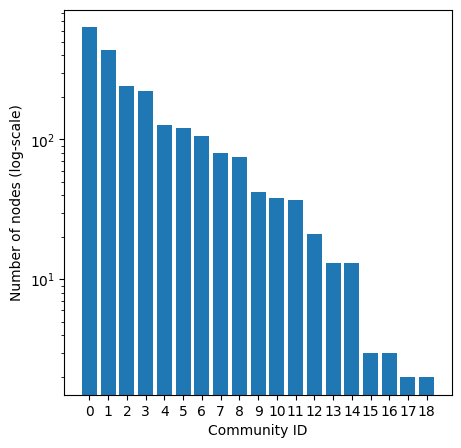

In [251]:
plt.figure(figsize=(5, 5))

communities_counts = np.unique(communities_df["community"], return_counts=True)

plt.bar(communities_counts[0], communities_counts[1])

plt.yscale("log")
plt.xlabel("Community ID")
plt.xticks(communities_counts[0])
plt.ylabel("Number of nodes (log-scale)")

plt.show()

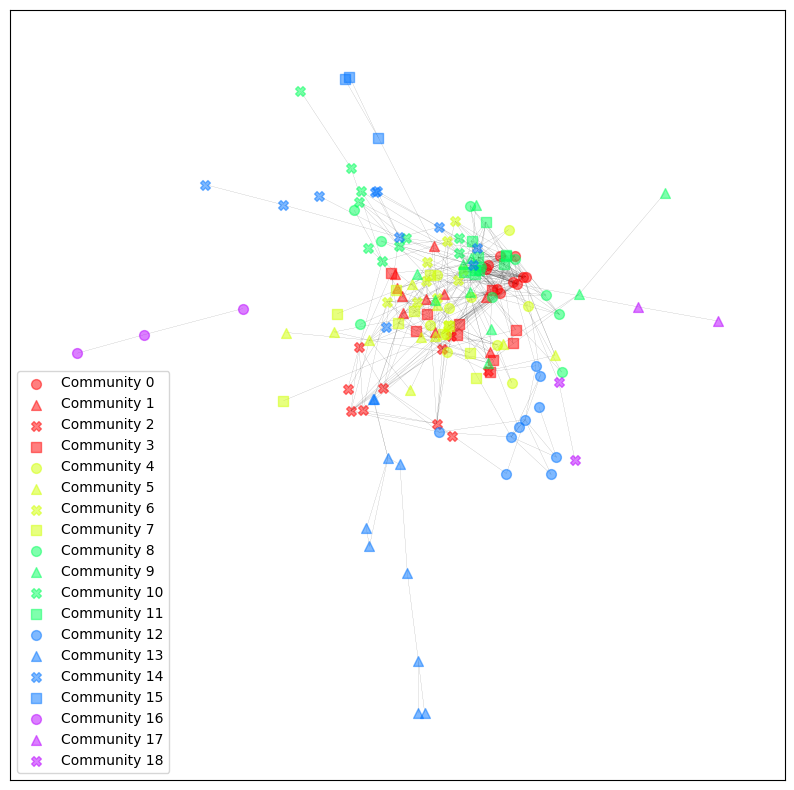

In [252]:
n_colors=6
n_shapes = 4
cmap = plt.cm.get_cmap("hsv", n_colors)

pos = nx.spring_layout(gx)

shapes = ["o", "^", "X", "s"]

plt.figure(figsize=(10, 10))

nodes_to_plot = []

# Plot nodes
for community in communities_df["community"].unique():
    community_members = communities_df[communities_df["community"] == community].sort_values(by="centrality", ascending=False)[:10]
    
    nx.draw_networkx_nodes(gx, pos, community_members["node_id"].to_list(), node_color=rgb2hex(cmap(int(community / n_shapes))), node_size=50, node_shape=shapes[community % n_shapes], alpha=0.5, label=f"Community {community}")
    
    nodes_to_plot += community_members["node_id"].to_list()
    
# Plot edges
edge_list = [edge for edge in list(gx.edges()) if edge[0] != edge[1] and edge[0] in nodes_to_plot and edge[1] in nodes_to_plot]
# edge_list = [edge for edge in list(gx.edges())]
nx.draw_networkx_edges(gx, pos, edgelist=edge_list, width=0.1, alpha=0.3, arrows=False)

plt.legend()
plt.show()